In [4]:
using Revise
using BilevelTrajOpt

using RigidBodyDynamics
using Plots
gr(size=(500,500), html_output_format=:png);

In [5]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
velocity_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
μ = 0.5
motion_type = :xyz
point = Point3D(default_frame(findbody(mechanism, "floor")), [0.,0.,0.])
normal = FreeVector3D(default_frame(findbody(mechanism, "floor")), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005;

In [79]:
q0 = [1., 0., 0., 0., 0., 0., 0.]
v0 = [0., 0., 0., 0.01, 0., 0.]
N = 10

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

ctrl! = (u,t,x) -> u[:] .= 0.;

In [ ]:
println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate_ipopt(x0,env,Δt,N,ctrl!,implicit_contact=false);

In [ ]:
println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate_ipopt(x0,env,Δt,N,ctrl!,implicit_contact=true);

In [92]:
println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate_snopt(x0,env,Δt,N,ctrl!,implicit_contact=false);

Explicit Contacts
  0.267717 seconds (758.71 k allocations: 41.200 MiB, 12.32% gc time)
  0.000761 seconds (1.76 k allocations: 272.844 KiB)
  0.000785 seconds (1.76 k allocations: 272.844 KiB)
  0.000738 seconds (1.76 k allocations: 272.844 KiB)
  0.000761 seconds (1.76 k allocations: 272.844 KiB)
  0.000761 seconds (1.76 k allocations: 272.844 KiB)
  0.000722 seconds (1.76 k allocations: 272.844 KiB)
Finished successfully: optimality conditions satisfied
  0.000715 seconds (1.76 k allocations: 272.844 KiB)
  0.000742 seconds (1.76 k allocations: 272.844 KiB)
  0.000738 seconds (1.76 k allocations: 272.844 KiB)
Finished successfully: optimality conditions satisfied
  0.000732 seconds (1.76 k allocations: 272.844 KiB)
  0.000752 seconds (1.76 k allocations: 272.844 KiB)
Finished successfully: optimality conditions satisfied
  0.000763 seconds (1.76 k allocations: 272.844 KiB)
  0.000751 seconds (1.76 k allocations: 272.844 KiB)
Finished successfully: optimality conditions satisfied
  0

In [93]:
println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate_snopt(x0,env,Δt,N,ctrl!,implicit_contact=true);

Implicit Contacts
199.502347 seconds (48.72 M allocations: 2.793 GiB, 1.30% gc time)
  1.216877 seconds (3.54 M allocations: 962.052 MiB, 41.49% gc time)
  1.217389 seconds (3.54 M allocations: 962.058 MiB, 41.62% gc time)
Finished successfully: feasible point found
  1.220728 seconds (3.54 M allocations: 962.059 MiB, 41.67% gc time)
  1.231066 seconds (3.54 M allocations: 962.059 MiB, 41.83% gc time)
  1.256860 seconds (3.54 M allocations: 962.059 MiB, 40.71% gc time)
  1.257281 seconds (3.54 M allocations: 962.058 MiB, 41.49% gc time)
  1.242209 seconds (3.54 M allocations: 962.059 MiB, 41.49% gc time)
  1.212393 seconds (3.54 M allocations: 962.052 MiB, 41.75% gc time)
  1.424958 seconds (3.54 M allocations: 962.059 MiB, 37.22% gc time)
  1.248705 seconds (3.54 M allocations: 962.058 MiB, 41.86% gc time)
  1.250343 seconds (3.54 M allocations: 962.059 MiB, 41.92% gc time)
  1.212761 seconds (3.54 M allocations: 962.059 MiB, 41.30% gc time)
  1.235943 seconds (3.54 M allocations: 962

  1.292558 seconds (3.54 M allocations: 962.059 MiB, 40.33% gc time)
  1.265189 seconds (3.54 M allocations: 962.059 MiB, 40.24% gc time)
  1.205660 seconds (3.54 M allocations: 962.059 MiB, 41.44% gc time)
  1.206996 seconds (3.54 M allocations: 962.059 MiB, 41.41% gc time)
  1.202767 seconds (3.54 M allocations: 962.059 MiB, 41.43% gc time)
  1.214168 seconds (3.54 M allocations: 962.059 MiB, 41.38% gc time)
  1.193922 seconds (3.54 M allocations: 962.059 MiB, 40.84% gc time)
Terminated after numerical difficulties: current point cannot be improved
  1.214496 seconds (3.54 M allocations: 962.052 MiB, 41.44% gc time)
  1.209180 seconds (3.54 M allocations: 962.052 MiB, 41.45% gc time)
  1.210651 seconds (3.54 M allocations: 962.059 MiB, 41.35% gc time)
  1.212436 seconds (3.54 M allocations: 962.059 MiB, 41.41% gc time)
  1.228401 seconds (3.54 M allocations: 962.059 MiB, 41.19% gc time)
  1.231479 seconds (3.54 M allocations: 962.059 MiB, 41.37% gc time)
  1.252459 seconds (3.54 M al

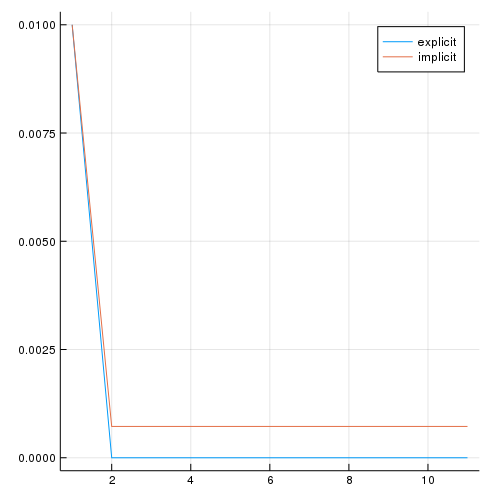

In [94]:
ts = cumsum([Δt for i in 1:N]);
j = 11
plot(traj_exp[j,:],label="explicit")
plot!(traj_imp[j,:],label="implicit")